In [53]:
import os
import sys
import time
import platform
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.io import imread
import matplotlib.pyplot as plt

import cv2
import shutil
from pathlib import Path
import matplotlib.gridspec as gridspec

In [54]:
'''
class 0 = whippet 惠比特犬
class 1 = Walker_hound 沃克獵犬
class 2 = fox_terrier 剛毛獵狐梗犬
class 3 = basset 巴吉度獵犬
class 4 = beagle 米格魯
class 5 = papillon 蝴蝶犬
class 6 = Norfolk_terrier 諾福克梗犬
class 7 = Blenheim_spaniel 布倫海姆犬
'''

'\nclass 0 = whippet 惠比特犬\nclass 1 = Walker_hound 沃克獵犬\nclass 2 = fox_terrier 剛毛獵狐梗犬\nclass 3 = basset 巴吉度獵犬\nclass 4 = beagle 米格魯\nclass 5 = papillon 蝴蝶犬\nclass 6 = Norfolk_terrier 諾福克梗犬\nclass 7 = Blenheim_spaniel 布倫海姆犬\n'

# VGG16 model

In [73]:
VGG_MEAN = [103.939, 116.779, 123.68]  


class My_Vgg16:
    def __init__(self, vgg16_npy_path, img_size=112, n_output = 8):
        self.data_dict = np.load(vgg16_npy_path, encoding='latin1').item()
        self.img_size = img_size
        print("npy file loaded")


    def _max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                              padding='SAME', name=name)

    def _conv_layer(self, bottom, name):
        with tf.variable_scope(name) as scope:
            filt = self.get_conv_filter(name)
            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.relu(bias)
            return relu

    def get_conv_filter(self, name):
        return tf.Variable(self.data_dict[name][0], name="filter")
        # use tf.constant() to prevent retraining it accidentally

    def get_bias(self, name):
        return tf.Variable(self.data_dict[name][1], name="biases")
        # use tf.constant() to prevent retraining it accidentally
    
    def build(self, rgb, train=False):
        rgb_scaled = rgb * 255.0 # input image * 255

        # Convert RGB to BGR
        red, green, blue = tf.split(rgb_scaled, 3, 3)
        
        assert red.get_shape().as_list()[1:] == [self.img_size, self.img_size, 1]
        assert green.get_shape().as_list()[1:] == [self.img_size, self.img_size, 1]
        assert blue.get_shape().as_list()[1:] == [self.img_size, self.img_size, 1]
        
        # when train vgg16, substrct mean if the image pre-processing method at that time
        bgr = tf.concat([
                 blue  - VGG_MEAN[0],
                 green - VGG_MEAN[1],
                 red   - VGG_MEAN[2],
                       ], 3)
        assert bgr.get_shape().as_list()[1:] == [self.img_size, self.img_size, 3]
        
        
        self.conv1_1 = self._conv_layer(bgr, "conv1_1")
        self.conv1_2 = self._conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self._max_pool(self.conv1_2, 'pool1')
        
        print(self.pool1.shape)

        self.conv2_1 = self._conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self._conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self._max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self._conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self._conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self._conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self._max_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self._conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self._conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self._conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self._max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self._conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self._conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self._conv_layer(self.conv5_2, "conv5_3")
        self.pool5 = self._max_pool(self.conv5_3, 'pool5')
        
        shape_pool5 = self.pool5.get_shape().as_list()[1:]
        assert 'pool5', shape_pool5 == [self.img_size/28, self.img_size/28, 512]
        
        """ 
        The new fully connected layers
        """
        dim1 = np.prod(shape_pool5) # 4*4*512 = 8192
        dim2 = 512
        n_output = 8 # number of classes = car makes
        fc_weights  = {
            'wd1': tf.Variable(tf.random_normal([dim1, dim2], stddev=0.1), name='wd1'),
            'wd2': tf.Variable(tf.random_normal([dim2, n_output], stddev=0.1), name='wd2')
            }
        
        fc_biases   = {
            'bd1': tf.Variable(tf.random_normal([dim2], stddev=0.1), name='bd1'),
            'bd2': tf.Variable(tf.random_normal([n_output], stddev=0.1), name='bd2')
            }
        
        x = tf.reshape(self.pool5, [-1, dim1], name="flat_pool5")
        self.fc6 = tf.nn.bias_add(tf.matmul(x, fc_weights['wd1']), fc_biases['bd1'], name="fc6")
        self.relu6 = tf.nn.relu(self.fc6)
        
        # Training with dropout
        self.relu6_dropout = tf.nn.dropout(self.relu6, 0.1)
        # the two outputs, logits is for training, probs for testing
        self.logits = tf.nn.bias_add(tf.matmul(self.relu6_dropout, 
                                               fc_weights['wd2']), 
                                               fc_biases['bd2'], name="logits")
        
        
        
        # Predicting
        self.logits_pred = tf.nn.bias_add(tf.matmul(
                                          self.relu6, 
                                          fc_weights['wd2']), 
                                          fc_biases['bd2'], 
                                          name="logits")
        self.probs_pred = tf.nn.softmax(self.logits_pred, name="probs")
        
        
        

# Data

In [74]:
label_dict = {
'whippet':0,
'Walker_hound':1,
'fox_terrier':2,
'basset':3,
'beagle':4,
'papillon':5,
'Norfolk_terrier':6,
'Blenheim_spaniel':7,
}

In [75]:
train_img_path = './training_set/'
test_img_path = './testing_set/'

In [76]:
img_size = 112

x_train = []
y_train = []

for img_dir in os.listdir(train_img_path):
    label = label_dict[img_dir]
    img_dir_path = os.path.join(train_img_path, img_dir)
    print(label, img_dir)
    for img_file in os.listdir(img_dir_path):
    
        img_file_path = os.path.join(img_dir_path, img_file)
        
        try:
            pic = cv2.imread(img_file_path)
            pic = cv2.resize(pic, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
        except:
            continue
            
        x_train.append(pic)
        y_train.append(label)
    
    
x_data = np.array(x_train)
y_data = np.array(y_train)
        
        
def train_valid_split(x_data, y_data, train_p=0.85):
    assert x_data.shape[0] == y_data.shape[0], 'data shape is different!'
    idx = np.arange(x_data.shape[0])
    np.random.shuffle(idx)
    
    train_idx = int(x_data.shape[0] * train_p) 
    x_train = x_data[idx[0:train_idx]]
    y_train = y_data[idx[0:train_idx]]
    x_test = x_data[idx[train_idx:]]
    y_test = y_data[idx[train_idx:]]
    return x_train, y_train, x_test, y_test


x_train, y_train, x_valid, y_valid = train_valid_split(x_data, y_data, train_p=0.7)

1 Walker_hound
6 Norfolk_terrier
5 papillon
0 whippet
2 fox_terrier
4 beagle
7 Blenheim_spaniel
3 basset


In [77]:
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(699, 112, 112, 3) (699,) (300, 112, 112, 3) (300,)


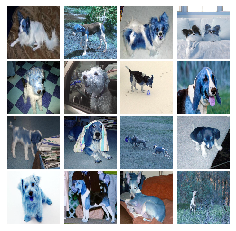

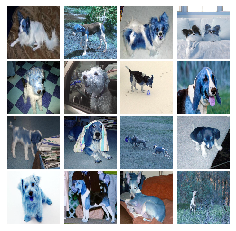

In [78]:
def plot(samples):
    '''Function to show image'''
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        #ax.set_aspect('equal')
        plt.imshow(sample, cmap='Greys_r')
    return fig

#Plot date
plot(x_train[400:416])

# Building Model

In [79]:
tf.reset_default_graph()

xs = tf.placeholder(tf.float32, [None, img_size, img_size, 3])
ys = tf.placeholder(tf.float32, [None])
# the VGG-16 weights are here: https://dl.dropboxusercontent.com/u/50333326/vgg16.npy
# Based on this implementation https://github.com/ry/tensorflow-vgg16

print('Environment :', platform.node().upper())
vgg16_npy_path = '../../models/pretrain_weight/vgg16.npy'

# Call Vgg16 class    
vgg = My_Vgg16(vgg16_npy_path=vgg16_npy_path, img_size=img_size)
with tf.name_scope("my_vgg16"):
    vgg.build(xs)


print('\ntrainable variables')
for v in tf.trainable_variables():
    print(v.name, v.get_shape().as_list())

"""
We want to train only the weights and biases of the two
fully connected layers.
"""
vars_to_optimize = [v for v in tf.trainable_variables() \
                        if v.name.startswith('my_vgg16/wd') \
                        or v.name.startswith('my_vgg16/bd')]

print('\nvariables to optimize')
for v in vars_to_optimize:
    print(v.name, v.get_shape().as_list())

    
learning_rate = 0.0001
loss = tf.reduce_mean(
       tf.nn.sparse_softmax_cross_entropy_with_logits(logits=vgg.logits, 
                                                      labels=tf.to_int64(ys)))




optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
"""
minimize with list of variables to update
"""
train_op = optimizer.minimize(loss, var_list=vars_to_optimize)

corr = tf.equal(tf.argmax(vgg.probs_pred, 1),  tf.to_int64(ys)) # count corrects
accr = tf.reduce_mean(tf.cast(corr, tf.float32)) # accuracy
init = tf.global_variables_initializer()

Environment : GCP-AUCM05
npy file loaded
(?, 56, 56, 64)

trainable variables
my_vgg16/conv1_1/filter:0 [3, 3, 3, 64]
my_vgg16/conv1_1/biases:0 [64]
my_vgg16/conv1_2/filter:0 [3, 3, 64, 64]
my_vgg16/conv1_2/biases:0 [64]
my_vgg16/conv2_1/filter:0 [3, 3, 64, 128]
my_vgg16/conv2_1/biases:0 [128]
my_vgg16/conv2_2/filter:0 [3, 3, 128, 128]
my_vgg16/conv2_2/biases:0 [128]
my_vgg16/conv3_1/filter:0 [3, 3, 128, 256]
my_vgg16/conv3_1/biases:0 [256]
my_vgg16/conv3_2/filter:0 [3, 3, 256, 256]
my_vgg16/conv3_2/biases:0 [256]
my_vgg16/conv3_3/filter:0 [3, 3, 256, 256]
my_vgg16/conv3_3/biases:0 [256]
my_vgg16/conv4_1/filter:0 [3, 3, 256, 512]
my_vgg16/conv4_1/biases:0 [512]
my_vgg16/conv4_2/filter:0 [3, 3, 512, 512]
my_vgg16/conv4_2/biases:0 [512]
my_vgg16/conv4_3/filter:0 [3, 3, 512, 512]
my_vgg16/conv4_3/biases:0 [512]
my_vgg16/conv5_1/filter:0 [3, 3, 512, 512]
my_vgg16/conv5_1/biases:0 [512]
my_vgg16/conv5_2/filter:0 [3, 3, 512, 512]
my_vgg16/conv5_2/biases:0 [512]
my_vgg16/conv5_3/filter:0 [3, 

# Training Process

In [82]:
loss_list = []
train_acc_list = []
test_acc_list = []

with tf.Session() as sess:
    sess.run(init)
    
    batch_size = 100
    whole_batch = int(x_train.shape[0] / batch_size)

    for epoch in range(100):
        for batch in range(whole_batch):
            batch_xs = x_train[batch*batch_size:(batch+1)*batch_size]
            batch_ys = y_train[batch*batch_size:(batch+1)*batch_size]
            # compute average loss and accuracy for each batch
            _, batch_cost = sess.run([train_op, loss],
                                      feed_dict={xs: batch_xs, ys: batch_ys})
            
            #loss_list.append(batch_cost)
            
        
        train_acc = sess.run(accr, feed_dict={xs: x_train, ys: y_train})
        test_acc = sess.run(accr, feed_dict={xs: x_valid, ys: y_valid})
        
        #train_acc_list.append(train_acc)
        #test_acc_list.append(test_acc)
        print("cost: %.9f, train_acc: %.9f, test_acc: %.9f" % (batch_cost, train_acc, test_acc))    
        

cost: 268531.250000000, train_acc: 0.163090125, test_acc: 0.103333332
cost: 258782.453125000, train_acc: 0.167381972, test_acc: 0.126666665
cost: 260611.765625000, train_acc: 0.190271810, test_acc: 0.136666670
cost: 222279.218750000, train_acc: 0.221745357, test_acc: 0.146666661
cost: 226908.875000000, train_acc: 0.240343347, test_acc: 0.156666666
cost: 230000.265625000, train_acc: 0.266094416, test_acc: 0.176666662
cost: 209835.312500000, train_acc: 0.291845500, test_acc: 0.189999998
cost: 188465.921875000, train_acc: 0.314735323, test_acc: 0.213333338
cost: 219199.406250000, train_acc: 0.323319018, test_acc: 0.236666664
cost: 170017.718750000, train_acc: 0.350500703, test_acc: 0.256666660
cost: 199389.765625000, train_acc: 0.359084398, test_acc: 0.256666660
cost: 168371.562500000, train_acc: 0.380543619, test_acc: 0.273333341
cost: 175825.265625000, train_acc: 0.402002871, test_acc: 0.289999992
cost: 172494.125000000, train_acc: 0.430615157, test_acc: 0.310000002
cost: 178165.0937500

KeyboardInterrupt: 